In [65]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

import numpy as np
import matplotlib.pyplot as plt

In [66]:
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')

print('DEVICE = ',DEVICE)

DEVICE =  cuda


In [67]:
BATCH_SIZE = 32
EPOCHS = 10

# Augmentation 적용
train_dataset = datasets.CIFAR10(root = "../data/CIFAR10" ,
                                 train = True, download = True, 
                                 transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                                                  transforms.ToTensor(),
                                                                  transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]))
test_dataset = datasets.CIFAR10(root = "../data/CIFAR10" , train = False, 
                                transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                                                  transforms.ToTensor(),
                                                                  transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]))

train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader  = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE, shuffle = False)

Files already downloaded and verified


In [68]:
for (x_train, y_train) in train_loader:
  print('x_train : ', x_train.size(), 'type : ',x_train.type())
  break

x_train :  torch.Size([32, 3, 32, 32]) type :  torch.FloatTensor


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

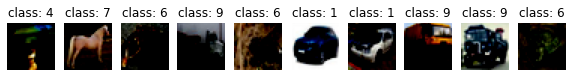

In [69]:
pltsize = 1  #이미지 크기설정
plt.figure(figsize=(10*pltsize,pltsize))  #그래프 사이의 거리 설정

for i in range(10):
  plt.subplot(1, 10, i+1)
  plt.axis('off')
  plt.imshow(np.transpose(x_train[i], (1,2,0)))
  plt.title('class: '+ str(y_train[i].item()))

In [70]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__()

    self.conv1 = nn.Conv2d(in_channels=3,out_channels=8,kernel_size=3,padding=1)
    self.conv2 = nn.Conv2d(in_channels=8,out_channels=16,kernel_size=3,padding=1)
    self.pool = nn.MaxPool2d(kernel_size = 2, stride =2)
    self.fc1 = nn.Linear(8*8*16, 64)
    self.fc2 = nn.Linear(64,32)
    self.fc3 = nn.Linear(32,10)
  
  def forward(self,x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.pool(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = self.pool(x)

    x = x.view(-1,8*8*16)       
    x = self.fc1(x)
    x = F.relu(x)     
    x = self.fc2(x)
    x = F.relu(x)   
    x = self.fc3(x)
    x = F.log_softmax(x)

    return x

In [71]:
# ResNet

class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride = 1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size = 3, stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size = 1, stride = stride, bias = False),
                nn.BatchNorm2d(planes))
    
    def forward(self, x):
        out = self.bn1(self.conv1(x))
        out = F.relu(out)
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [72]:
class ResNet(nn.Module):
    def __init__(self, num_classes = 10):
        super(ResNet, self).__init__()
        self.in_planes = 16
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(16, 2, stride = 1)
        self.layer2 = self._make_layer(32, 2, stride = 2)
        self.layer3 = self._make_layer(64, 2, stride = 2)
        self.layer4 = self._make_layer(128,2, stride = 2)
        self.linear = nn.Linear(128, num_classes)
        
    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks  - 1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [73]:
model = ResNet().to(DEVICE)
#optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)   
criterion = nn.CrossEntropyLoss()

print(model)
print(optimizer)

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=

In [74]:
def train(model, train_loader, optimizer,log_interval):
  model.train()
  for batch_idx, (image, label) in enumerate(train_loader):
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

In [75]:
def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for image, label in test_loader:
      image = image.to(DEVICE)
      label = label.to(DEVICE)
      output = model(image)
      test_loss += criterion(output, label).item()
      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy


In [76]:
for Epoch in range(1, 10+1):
  train(model, train_loader, optimizer,log_interval = 200)
  test_loss, test_accuracy = evaluate(model, test_loader)
  print("[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} %\n".format(Epoch,test_loss, test_accuracy))

[EPOCH: 1], 	Test Loss: 0.0321, 	Test Accuracy: 63.30 %

[EPOCH: 2], 	Test Loss: 0.0248, 	Test Accuracy: 72.58 %

[EPOCH: 3], 	Test Loss: 0.0226, 	Test Accuracy: 74.91 %

[EPOCH: 4], 	Test Loss: 0.0190, 	Test Accuracy: 79.05 %

[EPOCH: 5], 	Test Loss: 0.0181, 	Test Accuracy: 80.24 %

[EPOCH: 6], 	Test Loss: 0.0177, 	Test Accuracy: 80.17 %

[EPOCH: 7], 	Test Loss: 0.0166, 	Test Accuracy: 82.02 %

[EPOCH: 8], 	Test Loss: 0.0156, 	Test Accuracy: 83.11 %

[EPOCH: 9], 	Test Loss: 0.0160, 	Test Accuracy: 82.93 %

[EPOCH: 10], 	Test Loss: 0.0162, 	Test Accuracy: 82.93 %

